In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import pandas as pd
import numpy as np
import json
import os
import re
from typing import Tuple, Dict, Any, List

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from transformers import GPT2Model, AutoTokenizer, HubertModel, AutoFeatureExtractor
from huggingface_hub import notebook_login
from datasets import load_dataset

In [3]:
notebook_login()

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
hparams = {
    'train_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_train.flist',
    'dev_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_dev.flist',
    'test_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_test.flist',
    'gpt_only_text_dir': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/models/gpt2_asr_transcript_seed_0.pt',
    'seed': 0,
    'num_classes': 60,
    'gpt2_version': 'gpt2',
    'audio_embedding_version': 'facebook/hubert-base-ls960',
    'audio_dataset': 'danielroncel/dstc2_audios_input_hubert',
    'learning_rate': 5e-5,
    'num_epochs': 3,
    'log_interval': 100}

In [6]:
torch.manual_seed(hparams['seed'])

## 1) Load data

#### 1) Dialogues processed

In [7]:
dataset = load_dataset('danielroncel/dstc2_dialogues_transcript_input_gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/22266 [00:00<?, ? examples/s]

In [8]:
df = dataset['train'].to_pandas()

del dataset

print(len(df))
df.head()

22266


,session_id,audio_file,chat_history_last_9_tokenized,speaker_text_last_9_tokenized,attention_mask,label_semantics,label_semantics_encoded,label,label_encoded
0,voip-00d76b791d-20130327_010416,pt344x_0000993_0001219.wav,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|pricerange,45,request|food,55
1,voip-00d76b791d-20130327_010416,pt344x_0001649_0001680.wav,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|this,76,inform|area_inform|food_inform|pricerange_offe...,35
2,voip-00d76b791d-20130327_010416,pt344x_0002674_0002736.wav,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|addr,87,inform|addr_offer|name,34
3,voip-00d76b791d-20130327_010416,pt344x_0003533_0003611.wav,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|food,101,inform|area_inform|pricerange_offer|name,40
4,voip-00d76b791d-20130327_011116,pt344x_0001082_0001294.wav,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|food,42,request|food,55


In [9]:
df['chat_history_last_9_tokenized'] = df['chat_history_last_9_tokenized'].apply(lambda x: list(x))
df['speaker_text_last_9_tokenized'] = df['speaker_text_last_9_tokenized'].apply(lambda x: list(x))
df['attention_mask'] = df['attention_mask'].apply(lambda x: list(x))

### 1.2) idx2inform

In [10]:
df_label = df[['label', 'label_encoded']]
df_label = df_label.drop_duplicates('label_encoded')\
                   .sort_values(by='label_encoded', ascending=True)
print(len(df_label))
df_label.head()

60


,label,label_encoded
5930,canthelp.exception|name_canthelp|area_canthelp...,0
5546,canthelp.exception|name_canthelp|area_canthelp...,1
5627,canthelp.exception|name_canthelp|area_canthelp...,2
6250,canthelp.exception|name_canthelp|food,3
5800,canthelp.exception|name_canthelp|food_canthelp...,4


In [11]:
idx2inform = list()

for idx, row in df_label.iterrows():

  row_inform = list()

  label = row['label']
  label = label.split('_')

  for item in label:
    if 'inform' in item:
      row_inform.append(item.split('|')[1])

  idx2inform.append(set(row_inform))

idx2inform[20:30]

[set(),
 {'count'},
 {'count'},
 set(),
 {'count'},
 {'count'},
 {'addr', 'food', 'phone'},
 {'addr', 'food'},
 {'addr', 'phone', 'postcode'},
 {'addr', 'phone', 'pricerange'}]

## 3) idx2semantic

In [12]:
df_label = df[['label_semantics', 'label_semantics_encoded']]
df_label = df_label.drop_duplicates('label_semantics_encoded')\
                   .sort_values(by='label_semantics_encoded', ascending=True)
print(len(df_label))
df_label.head()

113


,label_semantics,label_semantics_encoded
14,,0
294,ack,1
17733,ack_inform|food_reqalts,2
5540,ack_inform|this,3
9625,ack_reqalts,4


In [13]:
idx2semantic = list()

for idx, row in df_label.iterrows():

  row_inform = list()

  label = row['label_semantics']
  label = label.split('_')

  for item in label:
    if 'request' in item:
      row_inform.append(item.split('|')[1])

  idx2semantic.append(set(row_inform))

idx2semantic[60:70]

[set(),
 set(),
 set(),
 {'addr', 'area'},
 {'area'},
 {'signature'},
 set(),
 {'addr'},
 {'addr', 'phone'},
 {'food'}]

In [14]:
del df_label

#### 1.2) Audios

In [15]:
dataset = load_dataset(hparams['audio_dataset'])

Generating train split:   0%|          | 0/25516 [00:00<?, ? examples/s]

In [16]:
df_audios = dataset['train'].to_pandas()

In [17]:
del dataset

In [18]:
df_audios = df_audios.rename({'session_ids': 'session_id',
                              'path': 'audio_file'}, axis=1)

In [19]:
df_audios.head()

,session_id,audio_file,input_values
0,voip-00d76b791d-20130327_010416,pt344x_0000993_0001219.wav,"[0.0084459325, 0.0084459325, 0.0025093406, -0...."
1,voip-00d76b791d-20130327_010416,pt344x_0001649_0001680.wav,"[0.0034742623, 0.00435598, 0.009646287, 0.0096..."
2,voip-00d76b791d-20130327_010416,pt344x_0002674_0002736.wav,"[0.0030231818, 0.0030231818, 0.006158771, 0.01..."
3,voip-00d76b791d-20130327_010416,pt344x_0003533_0003611.wav,"[0.005288514, 0.01527205, 0.018902427, 0.01527..."
4,voip-00d76b791d-20130327_010416,pt344x_0004453_0004531.wav,"[0.005022339, 0.008258534, 0.0066404366, 0.002..."


#### 1.3) Merge text and audio

In [20]:
print(df.shape[0])
df = df.merge(df_audios, on=['audio_file', 'session_id'], how='inner')\
       .drop(['audio_file',], axis=1)
print(df.shape[0])

del df_audios

df.head()

22266
22266


,session_id,chat_history_last_9_tokenized,speaker_text_last_9_tokenized,attention_mask,label_semantics,label_semantics_encoded,label,label_encoded,input_values
0,voip-00d76b791d-20130327_010416,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|pricerange,45,request|food,55,"[0.0084459325, 0.0084459325, 0.0025093406, -0...."
1,voip-00d76b791d-20130327_010416,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|this,76,inform|area_inform|food_inform|pricerange_offe...,35,"[0.0034742623, 0.00435598, 0.009646287, 0.0096..."
2,voip-00d76b791d-20130327_010416,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|addr,87,inform|addr_offer|name,34,"[0.0030231818, 0.0030231818, 0.006158771, 0.01..."
3,voip-00d76b791d-20130327_010416,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|food,101,inform|area_inform|pricerange_offer|name,40,"[0.005288514, 0.01527205, 0.018902427, 0.01527..."
4,voip-00d76b791d-20130327_011116,"[50257, 15496, 837, 7062, 284, 262, 14457, 707...","[50257, 50257, 50257, 50257, 50257, 50257, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|food,42,request|food,55,"[-6.28221e-05, -0.0015946792, -0.0015946792, -..."


## 2) Train/Test split

In [21]:
assert df['label'].nunique() == hparams['num_classes']

In [22]:
# load train session ids
with open(hparams['train_split'], 'r') as file:
  lines = file.readlines()

  train_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    train_session_ids.append(session_id)

In [23]:
# load dev session ids
with open(hparams['dev_split'], 'r') as file:
  lines = file.readlines()

  dev_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    dev_session_ids.append(session_id)

In [24]:
# load test session ids
with open(hparams['test_split'], 'r') as file:
  lines = file.readlines()

  test_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    test_session_ids.append(session_id)

In [25]:
# built the final test set by adding the dev set, as done in the paper
#test_session_ids = test_session_ids + dev_session_ids

In [26]:
print(f"Train samples: {len(train_session_ids)}")
print(f"Dev samples: {len(dev_session_ids)}")
print(f"Test samples: {len(test_session_ids)}")

Train samples: 1612
Dev samples: 506
Test samples: 1117


In [27]:
df_train = df[df['session_id'].isin(train_session_ids)]
df_dev = df[df['session_id'].isin(dev_session_ids)]
df_test = df[df['session_id'].isin(test_session_ids)]

print(f"Train messages: {len(df_train)} ({df_train['session_id'].nunique()} dialogues)")
print(f"Dev messages: {len(df_dev)} ({df_dev['session_id'].nunique()} dialogues)")
print(f"Test messages: {len(df_test)} ({df_test['session_id'].nunique()} dialogues)")

Train messages: 10065 (1612 dialogues)
Dev messages: 3428 (506 dialogues)
Test messages: 8773 (1117 dialogues)


In [28]:
del train_session_ids, dev_session_ids, test_session_ids

## 2) Define dataset and model

#### 2.1) Load pretrained model text-only

In [29]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

new_tokens = ["<sys>", "<user>" ,"<DA_pred>"]

# check if the tokens are already in the vocabulary
new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

# modify the tokenizer to take into account the new token
tokenizer.add_tokens(list(new_tokens))

# Add padding token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [30]:
class MultiHeadAttention(nn.Module):

    """
        Sequence to sequence component, the input dimension is the same than the output dimension.
        Sequence length is not fixed.
        emb_in is the dimension of every input vector (embedding).
        heads is the number of heads to use in the Multi-Head Attention.
    """

    def __init__(self, emb_in, heads):

        super().__init__()

        self.emb_in = emb_in
        self.emb_out = emb_in # HACK we force the same input and output dimension
        self.heads = heads

        self.init_matrix_transformations()


    def init_matrix_transformations(self):

        # Matrix transformations to stack every head keys, queries and values matrices
        self.to_keys = nn.Linear(self.emb_in, self.emb_out * self.heads, bias=False)
        self.to_queries = nn.Linear(self.emb_in, self.emb_out * self.heads, bias=False)
        self.to_values = nn.Linear(self.emb_in, self.emb_out * self.heads, bias=False)

        # Linear projection. For each input vector we get self.heads heads, we project them into only one.
        self.unify_heads = nn.Linear(self.heads * self.emb_out, self.emb_out)

    def forward(self, input_tensors):

        b, t, e = input_tensors.size()
        assert e == self.emb_in, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb_in})'

        keys = self.to_keys(input_tensors).view(b, t, self.heads, self.emb_out)
        queries = self.to_queries(input_tensors).view(b, t, self.heads, self.emb_out)
        values = self.to_values(input_tensors).view(b, t, self.heads, self.emb_out)

        # 1 - Compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * self.heads, t, self.emb_out)
        queries = queries.transpose(1, 2).contiguous().view(b * self.heads, t, self.emb_out)
        values = values.transpose(1, 2).contiguous().view(b * self.heads, t, self.emb_out)

        # - Instead of dividing the dot products by sqrt(e), we scale the queries and keys.
        #   This should be more memory efficient
        queries = queries / (self.emb_out ** (1/4))
        keys    = keys / (self.emb_out ** (1/4))

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b * self.heads, t, t), f'Matrix has size {dot.size()}, expected {(b * self.heads, t, t)}.'

        dot = F.softmax(dot, dim = 2) # dot now has row-wise self-attention probabilities

        # 2 - Apply the self attention to the values
        output = torch.bmm(dot, values).view(b, self.heads, t, self.emb_out)

        # swap h, t back
        output = output.transpose(1, 2).contiguous().view(b, t, self.heads * self.emb_out)

        # unify heads
        output = self.unify_heads(output)

        return output

In [31]:
class AttentionPooling(nn.Module):

    def __init__(self, hidden_size):
        super(AttentionPooling, self).__init__()

        self.hidden_size = hidden_size

        self.u = nn.Parameter(torch.FloatTensor(self.hidden_size, 1))
        torch.nn.init.xavier_normal_(self.u)

    def forward(self, input_tensor):

        # Calculate attention scores
        attention_scores = torch.matmul(input_tensor, self.u.squeeze())

        # Divide each score by square root of hidden_size
        attention_scores /= (self.hidden_size ** 0.5)

        # Apply softmax along the N dimension to normalize scores
        attention_scores = F.softmax(attention_scores, dim=1)

        # Expand dimensions for broadcasting
        attention_scores = attention_scores.unsqueeze(2)

        # Weighted sum using attention weights
        weighted_sum = torch.sum(input_tensor * attention_scores, dim=1)

        return weighted_sum

In [32]:
class GPT2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(GPT2Classifier, self).__init__()

        self.gpt2 = GPT2Model.from_pretrained(hparams['gpt2_version'])

        self.linear = nn.Linear(self.gpt2.config.hidden_size, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.gpt2.resize_token_embeddings(len(tokenizer))

    def forward(self, chat_history_tokens, speaker_tokens, attention_mask):

        # get token embedding
        word_embedding = self.gpt2.wte(chat_history_tokens)
        # get speaker embedding
        speaker_embedding = self.gpt2.wte(speaker_tokens)

        input_embedding = word_embedding + speaker_embedding

        output = self.gpt2(inputs_embeds=input_embedding,
                           attention_mask=attention_mask)

        last_hidden_states = output.last_hidden_state

        chat_history_embedding = last_hidden_states[:, -1, :]

        output = self.linear(chat_history_embedding)

        output = self.log_softmax(output)

        return output

#### 2.2) Define dataset

In [33]:
class DSTC2(Dataset):
    def __init__(self, data):

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        chat_history_tokens_tensor = torch.tensor(self.data['chat_history_last_9_tokenized'].iloc[idx])
        speaker_tokens_tensor = torch.tensor(self.data['speaker_text_last_9_tokenized'].iloc[idx])
        attention_mask_tensor = torch.tensor(self.data['attention_mask'].iloc[idx])
        audio = torch.tensor(self.data['input_values'].iloc[idx])

        semantics = torch.tensor(self.data['label_semantics_encoded'].iloc[idx], dtype=torch.int32)
        labels = torch.tensor(self.data['label_encoded'].iloc[idx], dtype=torch.int32)

        return chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio, semantics, labels

In [34]:
del df, session_id, new_tokens, lines, line, file

In [35]:
df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [36]:
train_dataset = DSTC2(df_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

dev_dataset = DSTC2(df_dev)
dev_loader = DataLoader(dev_dataset, batch_size=100, shuffle=True)

test_dataset = DSTC2(df_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [37]:
class GPT2HubertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(GPT2HubertClassifier, self).__init__()

        self.gpt2 = GPT2Model.from_pretrained(hparams['gpt2_version'])
        self.gpt2.resize_token_embeddings(len(tokenizer))

        self.gpt2_layer_weights = nn.Parameter(torch.randn(1, 12, 1, 1))

        self.audio_embedding_model = HubertModel.from_pretrained(hparams['audio_embedding_version'])
        self.audio_embedding_layer_weights = nn.Parameter(torch.randn(1, 12, 1, 1))

        self.mha = MultiHeadAttention(emb_in=768, heads=4)

        self.attention_pooling = AttentionPooling(768)

        self.linear = nn.Linear(768, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, chat_history_tokens, speaker_tokens, attention_mask, audio):

        # get token embedding
        word_embedding = self.gpt2.wte(chat_history_tokens)
        # get speaker embedding
        speaker_embedding = self.gpt2.wte(speaker_tokens)

        input_embedding = word_embedding + speaker_embedding

        output_gpt2 = self.gpt2(inputs_embeds=input_embedding,
                                attention_mask=attention_mask,
                                output_hidden_states=True)

        # Get hidden states: (batch_size, n_layers, n_tokens, hidden_size)
        chat_history_embedding = output_gpt2.hidden_states[1:]
        chat_history_embedding = torch.stack(chat_history_embedding, dim=1)
        # Multiply by the corresponding weights: (batch_size, n_layers, n_tokens, hidden_size)
        chat_history_embedding = chat_history_embedding * self.gpt2_layer_weights

        # Sum DA_pred token embeddings: (batch_size, n_tokens, hidden_size)
        chat_history_embedding = torch.sum(chat_history_embedding, axis=1)

        # Get hidden states: (batch_size, n_layers, n_tokens, hidden_size)
        audio_embedding = self.audio_embedding_model(audio, output_hidden_states=True)

        audio_embedding = torch.stack(audio_embedding.hidden_states[1:], dim=1)

        # Multiply by layer weights: (batch_size, n_layers, n_tokens, hidden_size)
        audio_embedding = audio_embedding * self.audio_embedding_layer_weights
        # Weighted sum: (batch_size, n_tokens, hidden_size)
        audio_embedding = torch.sum(audio_embedding, dim=1)

        # Concat text and audio embeddings: (batch_size, n_tokens + 1, hidden_size)
        final_embedding = torch.cat((audio_embedding, chat_history_embedding), dim=1)

        # Apply Multi-head attention
        final_embedding = self.mha(final_embedding)
        # Apply attention pooling
        final_embedding = self.attention_pooling(final_embedding)

        # Apply classifier
        output = self.linear(final_embedding)
        output = self.log_softmax(output)

        return output

In [38]:
model = GPT2HubertClassifier(num_classes=hparams['num_classes'])

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

## 3) Train

In [39]:
def compute_accuracy(predicted_batch: torch.Tensor, label_batch: torch.Tensor) -> float:
    """
    Define the Accuracy metric in the function below by:
      (1) obtain the maximum for each predicted element in the batch to get the
        class (it is the maximum index of the num_classes array per batch sample)
        (look at torch.argmax in the PyTorch documentation)
      (2) compare the predicted class index with the index in its corresponding
        neighbor within label_batch
      (3) sum up the number of affirmative comparisons and return the summation

    Parameters:
    -----------
    predicted_batch: torch.Tensor shape: [BATCH_SIZE, N_CLASSES]
        Batch of predictions
    label_batch: torch.Tensor shape: [BATCH_SIZE, 1]
        Batch of labels / ground truths.
    """
    pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    acum = pred.eq(label_batch.view_as(pred)).sum().item()
    return acum

In [40]:
def user_request_score(predicted_batch: torch.Tensor, semantic_batch: torch.Tensor) -> float:

    global idx2inform, idx2semantic

    pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability

    pred = pred.tolist()
    semantic_batch = semantic_batch.tolist()

    total_correct_sys_answers = 0
    total_user_requests = 0

    for i in range(len(semantic_batch)):
      user_requests = idx2semantic[semantic_batch[i]]
      sys_informs = idx2inform[pred[i][0]]

      correct_sys_answers = sys_informs.intersection(user_requests)

      total_correct_sys_answers += len(correct_sys_answers)
      total_user_requests += len(user_requests)

    return total_correct_sys_answers, total_user_requests

In [41]:
def train_epoch(
        train_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        optimizer: torch.optim,
        criterion: torch.nn.functional,
        epoch: int,
        log_interval: int,
        ) -> Tuple[float, float]:

    # Activate the train=True flag inside the model
    network.train()

    """
    for param in model.gpt2.parameters():
      param.requires_grad = False
    """
    for param in model.audio_embedding_model.parameters():
      param.requires_grad = False

    train_loss = []

    # acc = 0.0
    acc = list()

    # total_correct_sys_answers = 0
    # total_user_requests = 0
    total_correct_sys_answers = list()
    total_user_requests = list()

    for batch_idx, (chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio, semantic, target) in enumerate(train_loader, 1):

        chat_history_tokens_tensor = chat_history_tokens_tensor.to(device)
        speaker_tokens_tensor = speaker_tokens_tensor.to(device)
        attention_mask_tensor = attention_mask_tensor.to(device)
        audio = audio.to(device)
        semantic = semantic.type(torch.LongTensor).to(device)

        target = target.type(torch.LongTensor).to(device)

        optimizer.zero_grad()
        output = network(chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

         # Compute metrics
        #acc += compute_accuracy(output, target)
        acc.append(compute_accuracy(output, target))
        correct_sys_answers, user_requests = user_request_score(output, semantic)
        # total_correct_sys_answers += correct_sys_answers
        # total_user_requests += user_requests
        total_correct_sys_answers.append(correct_sys_answers)
        total_user_requests.append(user_requests)
        train_loss.append(loss.item())

        if batch_idx % log_interval == 0 or batch_idx >= len(train_loader):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAvg Loss: {:.6f}\tAvg Acc: {:.6f}%\tAvg URS: {:.6f}%'.format(
                epoch, batch_idx * len(chat_history_tokens_tensor), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                np.mean(train_loss[-log_interval:]),
                100. * sum(acc[-log_interval:]) / (log_interval * 4),
                100. * sum(total_correct_sys_answers[-log_interval:]) / sum(total_user_requests[-log_interval:])))

    avg_acc = 100. * sum(acc) / len(train_loader.dataset)
    avg_urs = 100. * sum(total_correct_sys_answers) / sum(total_user_requests)

    return np.mean(train_loss), avg_acc, avg_urs

In [42]:
@torch.no_grad() # decorator: avoid computing gradients
def eval_epoch(
        test_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        criterion: torch.nn.functional,
        ) -> Tuple[float, float]:

    # Dectivate the train=True flag inside the model
    network.eval()

    test_loss = 0
    acc = 0
    total_correct_sys_answers = 0
    total_user_requests = 0

    for (chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio, semantic, target) in test_loader:

        chat_history_tokens_tensor = chat_history_tokens_tensor.to(device)
        speaker_tokens_tensor = speaker_tokens_tensor.to(device)
        attention_mask_tensor = attention_mask_tensor.to(device)
        audio = audio.to(device)
        semantic = semantic.type(torch.LongTensor).to(device)
        target = target.type(torch.LongTensor).to(device)

        output = network(chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio)

        # Apply the loss criterion and accumulate the loss
        test_loss += criterion(output, target).item()

        # compute number of correct predictions in the batch
        acc += compute_accuracy(output, target)
        correct_sys_answers, user_requests = user_request_score(output, semantic)
        total_correct_sys_answers += correct_sys_answers
        total_user_requests += user_requests

    test_loss /= len(test_loader)
    # Average accuracy across all correct predictions batches now
    test_acc = 100. * acc / len(test_loader.dataset)
    test_urs = 100. * total_correct_sys_answers / total_user_requests
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%) , URS: {}/{} ({:.6f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc, total_correct_sys_answers, total_user_requests, test_urs
        ))
    return test_loss, test_acc, test_urs

In [43]:
optimizer = optim.Adam(model.parameters(), lr=hparams['learning_rate'])
scheduler = StepLR(optimizer, gamma=0.1, step_size=2)
criterion = nn.NLLLoss()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [44]:
tr_losses = []
tr_accs = []
tr_urss = []
dev_losses = []
dev_accs = []
dev_urss = []

model.to(device)

for epoch in range(1, hparams['num_epochs'] + 1):
  tr_loss, tr_acc, train_urs = train_epoch(train_loader, model, optimizer, criterion, epoch, hparams['log_interval'])
  dev_loss, dev_acc, dev_urs = eval_epoch(dev_loader, model, criterion)

  scheduler.step()

  tr_losses.append(tr_loss)
  tr_accs.append(tr_acc)
  tr_urss.append(train_urs)

  dev_losses.append(dev_loss)
  dev_accs.append(dev_acc)
  dev_urss.append(dev_urs)

Train Epoch: 1 [400/10065 (4%)]	Loss: 3.470887	Avg Loss: 4.830767	Avg Acc: 14.750000%	Avg URS: 17.307692%
Train Epoch: 1 [800/10065 (8%)]	Loss: 2.728492	Avg Loss: 2.653555	Avg Acc: 25.750000%	Avg URS: 25.157233%
Train Epoch: 1 [1200/10065 (12%)]	Loss: 3.852793	Avg Loss: 2.231916	Avg Acc: 35.500000%	Avg URS: 37.837838%
Train Epoch: 1 [1600/10065 (16%)]	Loss: 2.743003	Avg Loss: 2.115898	Avg Acc: 36.000000%	Avg URS: 50.757576%
Train Epoch: 1 [2000/10065 (20%)]	Loss: 1.217111	Avg Loss: 2.012044	Avg Acc: 40.750000%	Avg URS: 58.433735%
Train Epoch: 1 [2400/10065 (24%)]	Loss: 1.530519	Avg Loss: 1.952295	Avg Acc: 41.500000%	Avg URS: 55.000000%
Train Epoch: 1 [2800/10065 (28%)]	Loss: 1.938768	Avg Loss: 1.822143	Avg Acc: 47.000000%	Avg URS: 58.394161%
Train Epoch: 1 [3200/10065 (32%)]	Loss: 2.362999	Avg Loss: 1.758416	Avg Acc: 44.250000%	Avg URS: 68.275862%
Train Epoch: 1 [3600/10065 (36%)]	Loss: 2.525366	Avg Loss: 1.742593	Avg Acc: 45.250000%	Avg URS: 64.137931%
Train Epoch: 1 [4000/10065 (40%)

## 4) Evaluation

### Train

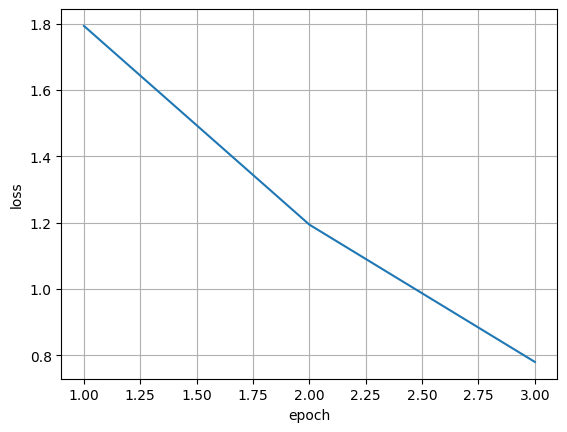

In [45]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], tr_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [46]:
tr_losses

[1.7935682222560525, 1.193766735638072, 0.7794769259863842]

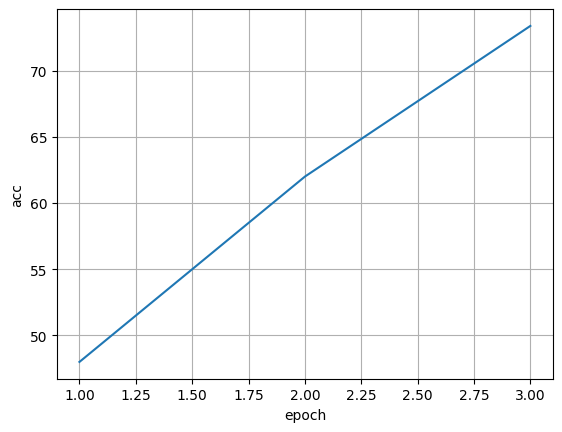

In [47]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], tr_accs)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

In [48]:
print(tr_accs)

[47.978142076502735, 62.00695479384004, 73.41281669150521]


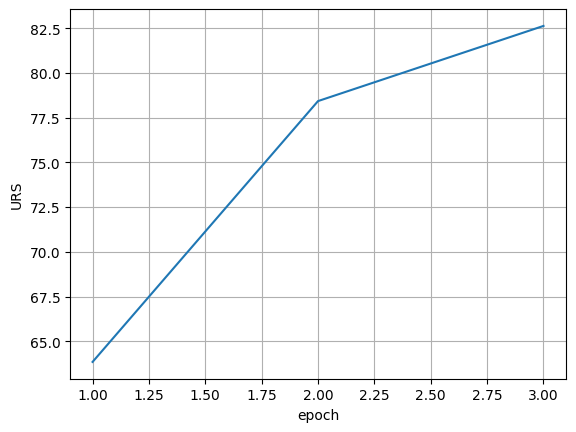

In [49]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], tr_urss)
plt.xlabel('epoch')
plt.ylabel('URS')
plt.grid()

In [50]:
tr_urss

[63.84847653033214, 78.42437551468569, 82.62421081526215]

### Dev

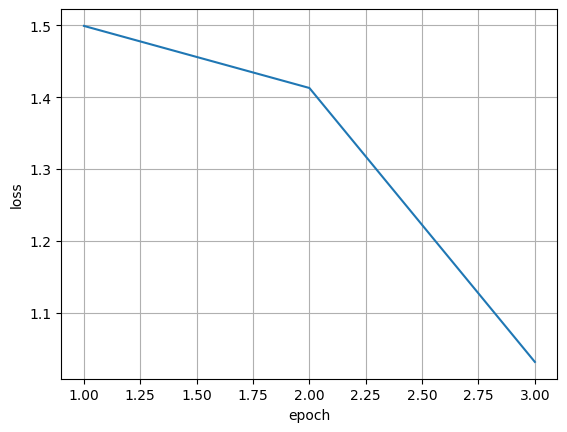

In [51]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], dev_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [52]:
dev_losses

[1.4990495341164725, 1.4127097061702183, 1.0316357680729458]

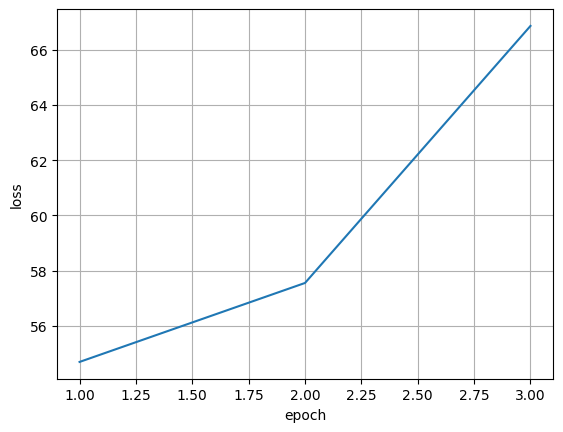

In [53]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], dev_accs)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [54]:
print(dev_accs)

[54.696616102683784, 57.55542590431739, 66.86114352392066]


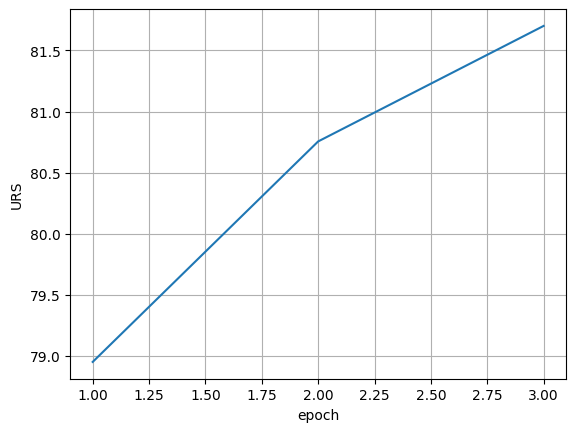

In [55]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], dev_urss)
plt.xlabel('epoch')
plt.ylabel('URS')
plt.grid()

In [56]:
dev_urss

[78.95189003436425, 80.75601374570446, 81.70103092783505]

### Test

In [57]:
test_loss, test_acc, test_urs = eval_epoch(test_loader, model, criterion)


Test set: Average loss: 3.2537, Accuracy: 3973/8773 (45.286675%) , URS: 1997/2515 (79.403579%)



In [58]:
test_loss, test_acc, test_urs

(3.2536657682873984, 45.28667502564687, 79.40357852882704)

## ??) Weight per layer

In [59]:
audio_embedding_layer_weights = model.audio_embedding_layer_weights.tolist()
audio_embedding_layer_weights = [l4 for l1 in audio_embedding_layer_weights for l2 in l1 for l3 in l2 for l4 in l3]
audio_embedding_layer_weights

[-0.8550694584846497,
 -0.015965204685926437,
 -1.4903453588485718,
 1.014068603515625,
 0.4278574287891388,
 -0.7332605719566345,
 -0.3210774064064026,
 1.5807616710662842,
 -0.09809456020593643,
 0.650549054145813,
 -0.5488553643226624,
 0.26433464884757996]

In [60]:
gpt2_layer_weights = model.gpt2_layer_weights.tolist()
gpt2_layer_weights = [l4 for l1 in gpt2_layer_weights for l2 in l1 for l3 in l2 for l4 in l3]
gpt2_layer_weights

[-0.22012025117874146,
 -0.07060634344816208,
 -1.62251877784729,
 -0.29900428652763367,
 -0.013125279918313026,
 0.3303864300251007,
 0.9518939852714539,
 -0.7873427271842957,
 1.1537805795669556,
 -0.22504068911075592,
 -1.961953043937683,
 -0.710085391998291]

## ?) Save model

In [61]:
#torch.save(model.state_dict(), 'gpt2_wav2vec2_transcript_seed_42.pt')